In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

tfd = tf.contrib.distributions

/Users/jattenberg/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def make_encoder(data, code_size):
    """
    The encoder maps an image to a proposed distribution
    over plausible codes for that image. This distribution 
    is also called the posterior, since it reflects our 
    belief of what the code should be for (i.e. after seeing) 
    a given image.
    """
    x = tf.layers.flatten(data)
    x = tf.layers.dense(x, 200, tf.nn.relu)
    x = tf.layers.dense(x, 200, tf.nn.relu)
    loc = tf.layers.dense(x, code_size)
    scale = tf.layers.dense(x, code_size, tf.nn.softplus)
    return tfd.MultivariateNormalDiag(loc, scale)

In [3]:
def make_prior(code_size):
    """
    The prior is fixed and defines what distribution of 
    codes we would expect. This provides a soft restriction 
    on what codes the VAE can use. It is often just a Normal 
    distribution with zero mean and unit variance.
    """
    loc = tf.zeros(code_size)
    scale = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scale)

In [4]:
def make_decoder(code, data_shape):
    """
    The decoder takes a code and maps it back to a 
    distribution of images that are plausible for the code. 
    It allows us to reconstruct images, or to generate new 
    images for any code we choose.
    
    Here, we use a Bernoulli distribution for the data, 
    modeling pixels as binary values. Depending on the type 
    and domain of your data, you may want to model it in a 
    different way, for example again as a Normal distribution.
    """
    x = tf.layers.dense(code, 200, tf.nn.relu)
    x = tf.layers.dense(x, 200, tf.nn.relu)
    logit = tf.layers.dense(x, np.prod(data_shape))
    logit = tf.reshape(logit, [-1] + data_shape)
    return tfd.Independent(tfd.Bernoulli(logit), 2) # tells TensorFlow that the inner two dimensions, width and height in our case, belong to the same data point, even though they have independent parameters. This allows us to evaluate the probability of an image under the distribution, not just individual pixels.

In [5]:
# allows reuse of model parameters
make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

In [6]:
"""
    evidence lower bound approximation of the likelihood of the 
    current data point given the current estimate of the code
    
    maximizing the ELBO maximizes the likelihood of the data given
    the current codes, while encouraging the codes to be close to 
    our prior belief of how codes should look like.
"""
data = tf.placeholder(tf.float32, [None, 28, 28])

prior = make_prior(code_size=2)
posterior = make_encoder(data, code_size=2)
code = posterior.sample()

likelihood = make_decoder(code, [28, 28]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)

In [7]:
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)
samples = make_decoder(prior.sample(10), [28, 28]).mean()

In [8]:
def plot_codes(ax, codes, labels):
    ax.scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
    ax.set_aspect('equal')
    ax.set_xlim(codes.min() - .1, codes.max() + .1)
    ax.set_ylim(codes.min() - .1, codes.max() + .1)
    ax.tick_params(
          axis='both', which='both', left='off', bottom='off',
          labelleft='off', labelbottom='off')
def plot_samples(ax, samples):
    for index, sample in enumerate(samples):
        ax[index].imshow(sample, cmap='gray')
        ax[index].axis('off')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 0, elbo: -544.043
Epoch 1, elbo: -171.43472
Epoch 2, elbo: -162.27852
Epoch 3, elbo: -158.49194
Epoch 4, elbo: -155.95482
Epoch 5, elbo: -154.21725
Epoch 6, elbo: -152.01453
Epoch 7, elbo: -150.70908
Epoch 8, elbo: -149.5014
Epoch 9, elbo: -148.79744
Epoch 10, elbo: -148.3922
Epoch 11, elbo: -147.71217
Epoch 12, elbo: -146.97916
Epoch 13, elbo: -146.76692
Epoch 14, elbo: -146.66225
Epoch 15, elbo: -145.55318
Epoch 16, elbo: -145.78513
Epoch 17, elbo: -145.24843
Epoch 18, elbo: -144.6389
Epoch 19, elbo: -144.65613


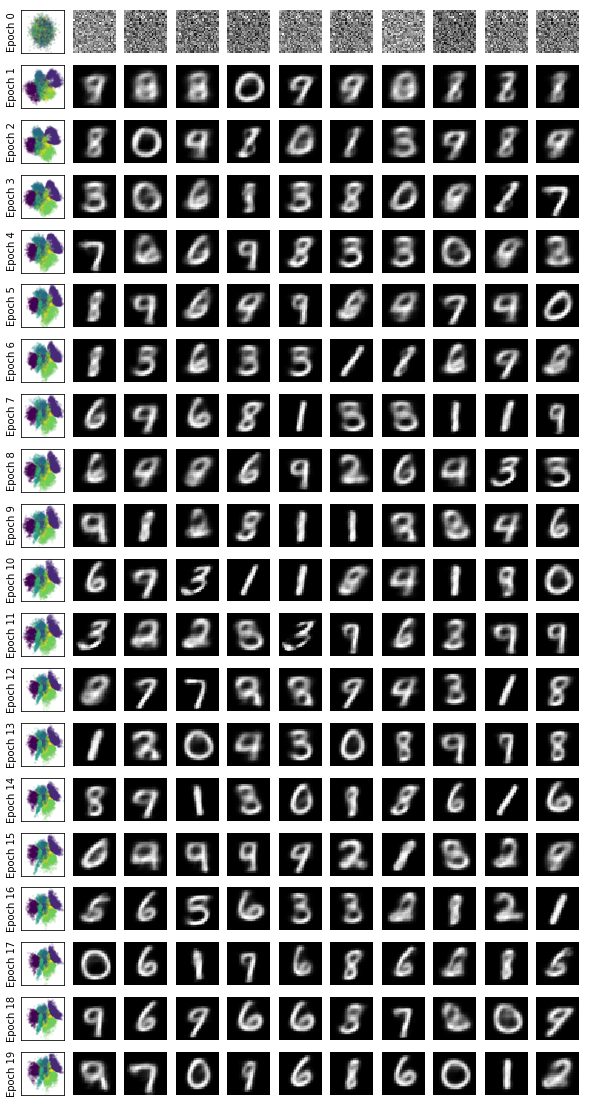

In [9]:
mnist = input_data.read_data_sets('MNIST_data/')
fig, ax = plt.subplots(nrows=20, ncols=11, figsize=(10, 20))

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)
for epoch in xrange(20):
    feed = {data: mnist.test.images.reshape([-1, 28, 28])}
    test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
    print "Epoch %s, elbo: %s" % (epoch, test_elbo)
    ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
    plot_codes(ax[epoch, 0], test_codes, mnist.test.labels)
    plot_samples(ax[epoch, 1:], test_samples)
    for _ in range(600):
        feed = {data: mnist.train.next_batch(100)[0].reshape([-1, 28, 28])}
        sess.run(optimize, feed)
plt.savefig('vae-mnist.png', dpi=300, transparent=True, bbox_inches='tight')